# Analisi dell'errore sulla predizione di immagini

In [9]:
# COMMON LIBRARIES
import os
import cv2
import requests
import json
import numpy as np
import torch
import random

import matplotlib.pyplot as plt
from datetime import datetime

from scipy.spatial import distance
from scipy.interpolate import interp1d

# DATA SET PREPARATION AND LOADING
from detectron2.data.datasets import register_coco_instances
from detectron2.data import DatasetCatalog, MetadataCatalog

# VISUALIZATION
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.visualizer import ColorMode

# CONFIGURATION
from detectron2 import model_zoo
from detectron2.config import get_cfg

# EVALUATION
from detectron2.engine import DefaultPredictor

# TRAINING
from detectron2.engine import DefaultTrainer

Dati globali

In [10]:
# Percorsi ai file COCO
base_path = os.getcwd()

# Costruisci i percorsi relativi alla posizione dello script
json_file = os.path.join(base_path, "../../annotations", "instances_val2017.json")
image_folder = os.path.join(base_path, "../../val2017/")

# Nome dell'immagine di cui trovare la bounding box
image_filenames = ["000000409475.jpg", "000000000872.jpg", "000000002153.jpg"]  # Sostituisci con il nome dell'immagine desiderata

#Modello pre-addestrato
MODEL_USED = "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"

### Estrapolazione dei dati
Estraggo dal json delle annotazioni le informazioni relative alle bounding boxe delle immagini da predire

dati: [x_min, y_min, width, height]

In [11]:
def extract_pixels_from_coco(image_filename, json_file):
    # 1. Caricare il file JSON con le annotazioni
    with open(json_file, "r") as f:
        coco_data = json.load(f)

    # 2. Creare una mappatura tra category_id e category_name
    category_dict = {category["id"]: category["name"] for category in coco_data["categories"]}

    # 3. Trovare i dati dell'immagine corrispondente al nome file
    image_data = next((img for img in coco_data["images"] if img["file_name"] == image_filename), None)

    if image_data is None:
        print("Immagine non trovata nel dataset COCO!")
        return []

    image_id = image_data["id"]
    image_width = image_data["width"]
    image_height = image_data["height"]

    # 4. Estrarre le segmentazioni associate a questa immagine
    extracted_data = []
    for ann in coco_data["annotations"]:
        if ann["image_id"] == image_id:
            category_id = ann["category_id"]
            category_name = category_dict.get(category_id, "Unknown")

            # Converte le segmentazioni in array di interi (ogni istanza può avere più poligoni)
            segmentation_pixels = [np.array(seg, dtype=np.int32).reshape((-1, 2)).tolist() for seg in ann["segmentation"]]

            extracted_data.append({
                "category_name": category_name,
                "pixels": segmentation_pixels,
                "image_width": image_width,
                "image_height": image_height
            })

    return extracted_data

def visualize_masks_on_image(image_filename, instances, image_folder):
    # Caricare l'immagine originale
    image_path = f"{image_folder}/{image_filename}"  # Percorso completo
    image = cv2.imread(image_path)  # Caricare immagine
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convertire in RGB per Matplotlib
    
    if not instances:
        print("Nessuna istanza trovata per questa immagine!")
        return
    
    image_width = instances[0]["image_width"]
    image_height = instances[0]["image_height"]

    # Creare una maschera vuota a colori
    mask_overlay = np.zeros((image_height, image_width, 3), dtype=np.uint8)

    for instance in instances:
        category_name = instance["category_name"]

        # Scegliere un colore casuale per questa istanza
        color = [random.randint(100, 255) for _ in range(3)]

        # Disegnare i poligoni sulla maschera
        for poly in instance["pixels"]:
            polygon = np.array(poly, dtype=np.int32)
            cv2.fillPoly(mask_overlay, [polygon], color=color)

    # Sovrapporre la maschera all'immagine originale con trasparenza
    alpha = 0.5  # Regola la trasparenza
    blended = cv2.addWeighted(image, 1, mask_overlay, alpha, 0)

    # Mostrare l'immagine originale e quella con maschere
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(image)
    ax[0].set_title("Immagine Originale")
    ax[0].axis("off")

    ax[1].imshow(blended)
    ax[1].set_title("Segmentazione Sovrapposta")
    ax[1].axis("off")

    plt.show()


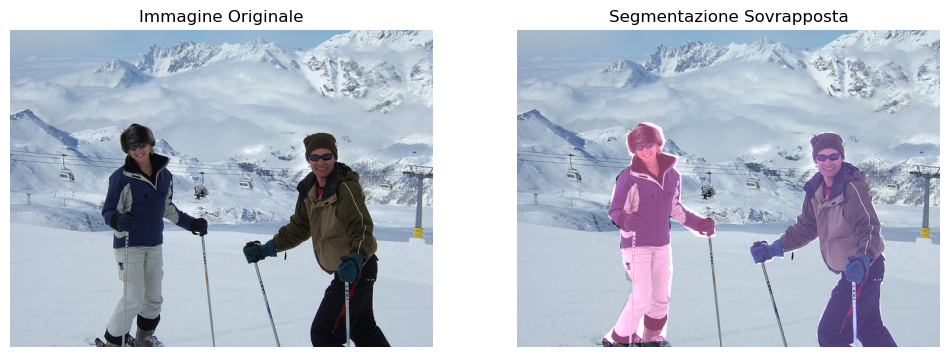

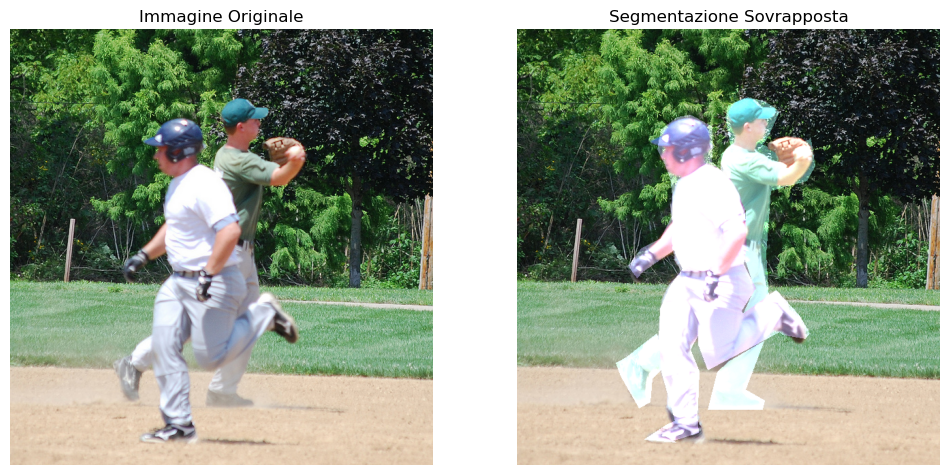

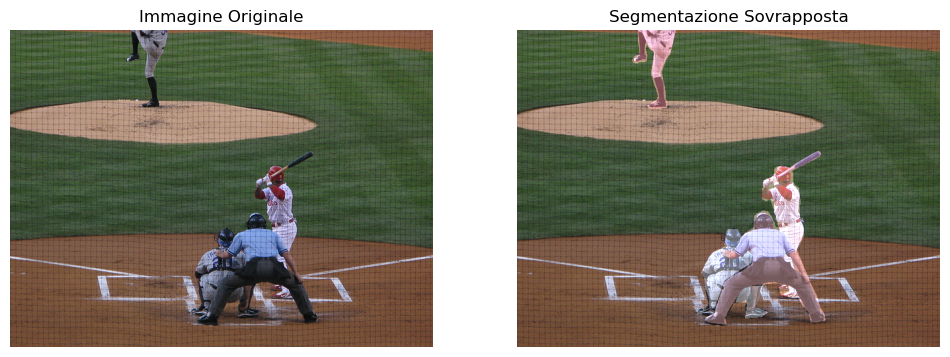

[{'category_name': 'person', 'pixels': [[[148, 447], [168, 409], [173, 396], [173, 378], [161, 356], [156, 318], [156, 299], [138, 283], [145, 243], [155, 219], [169, 207], [175, 192], [170, 190], [165, 172], [166, 157], [180, 148], [189, 141], [203, 141], [218, 149], [224, 169], [218, 185], [245, 192], [239, 210], [248, 218], [247, 263], [285, 285], [297, 289], [300, 312], [290, 314], [273, 313], [229, 279], [235, 364], [224, 465], [220, 470], [162, 474], [127, 470]]], 'image_width': 640, 'image_height': 480}
 {'category_name': 'person', 'pixels': [[[434, 238], [440, 229], [454, 217], [459, 214], [454, 206], [454, 201], [448, 198], [446, 190], [448, 184], [445, 172], [443, 165], [452, 160], [462, 156], [476, 155], [488, 160], [494, 167], [492, 174], [495, 181], [496, 189], [494, 201], [502, 200], [512, 206], [514, 212], [523, 216], [529, 220], [527, 229], [528, 235], [531, 242], [538, 255], [537, 260], [547, 286], [550, 301], [549, 309], [553, 313], [555, 323], [553, 334], [551, 336],

In [12]:
gt_instances = np.array([])
for file_name in image_filenames:
    # Estrarre i dati delle istanze segmentate
    instances = extract_pixels_from_coco(file_name, json_file)
    gt_instances = np.append(gt_instances, instances)
    # Visualizzare la segmentazione
    visualize_masks_on_image(file_name, instances, image_folder)

print(gt_instances)

In [13]:
def extract_polygons_from_masks(masks):
    """
    Converte le maschere binarie in poligoni (segmentazioni precise).
    """
    polygons = []
    for mask in masks:
        # Trova i contorni della maschera binaria (maschera di 1s e 0s)
        contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for contour in contours:
            # Appiattire il contorno in una lista di punti (x, y)
            polygon = contour.reshape(-1, 2).tolist()
            polygons.append(polygon)
    return polygons

def process_detectron2_output(image_filename, image_folder, model_used):
    # 1. Caricare l'immagine
    image = cv2.imread(image_folder + image_filename)
    
    # 2. Configurare il modello pre-addestrato di Detectron2
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file(model_used))
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # Imposta la soglia di confidenza
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(model_used)
    cfg.MODEL.DEVICE = "cpu"  # Usa la CPU (puoi cambiare con 'cuda' se hai una GPU)
    
    # 3. Inizializzare il predittore
    predictor = DefaultPredictor(cfg)
    
    # 4. Eseguire il modello sull'immagine
    outputs = predictor(image)
    print(outputs)
    # 5. Estrarre le istanze predette (classi, bounding boxes)
    instances = outputs["instances"].to("cpu")
    
    # 6. Ottenere il metadata (nomi delle classi)
    metadata = MetadataCatalog.get(cfg.DATASETS.TRAIN[0])
    
    # 7. Estrazione delle informazioni delle classi, bounding boxes e maschere
    category_ids = instances.pred_classes.numpy()  # ID delle classi
    bboxes = instances.pred_boxes.tensor.numpy()  # Bounding boxes
    masks = outputs["instances"].pred_masks.cpu().numpy()  # Shape: (N, H, W) (N=numero di istanze)
    
    # 8. Creare un array delle istanze predette con le informazioni desiderate
    boxes_predected = []
    
    for category_id, bbox, pred_mask in zip(category_ids, bboxes, masks):
        category_name = metadata.thing_classes[category_id]  # Ottieni il nome della categoria
        # Converti la maschera binaria in formato uint8
        mask_uint8 = (pred_mask * 255).astype(np.uint8)

        # Trova i contorni
        contours, _ = cv2.findContours(mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Converte i contorni in segmentazioni poligonali
        for contour in contours:
            if len(contour) > 2:  # Serve almeno un triangolo
                polygon = contour.reshape(-1, 2).tolist()  # Converte in lista di tuple [(x1,y1), (x2,y2), ...]
        
        # Aggiungi l'istanza al risultato
        boxes_predected.append({
            "category_name": category_name,
            "pixels": polygon,
            "image_width": image.shape[1],
            "image_height": image.shape[0]
        })

    # 9. Mostrare il risultato: maschere sovrapposte sull'immagine
    visualizer = Visualizer(image[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
    out = visualizer.draw_instance_predictions(instances)
    
    # Convertire l'immagine da BGR a RGB
    image_result = out.get_image()[:, :, ::-1]
    
    # Mostrare l'immagine con Matplotlib
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image[:, :, ::-1])
    plt.title("Immagine Originale")
    plt.axis("off")
    
    plt.subplot(1, 2, 2)
    plt.imshow(image_result)
    plt.title("Immagine con Maschere")
    plt.axis("off")
    
    plt.show()

    # Stampare le istanze predette
    for entry in boxes_predected:
        print(entry)
    return boxes_predected

### Predizione dei dati con Detectron2

{'instances': Instances(num_instances=4, image_height=480, image_width=640, fields=[pred_boxes: Boxes(tensor([[130.5354, 137.2014, 294.8878, 478.8391],
        [360.0284, 150.8438, 570.9359, 475.7864],
        [114.9404, 462.7374, 232.2243, 479.7992],
        [128.3991, 462.4725, 187.2576, 479.8150]])), scores: tensor([0.9998, 0.9997, 0.8857, 0.5422]), pred_classes: tensor([ 0,  0, 30, 30]), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  

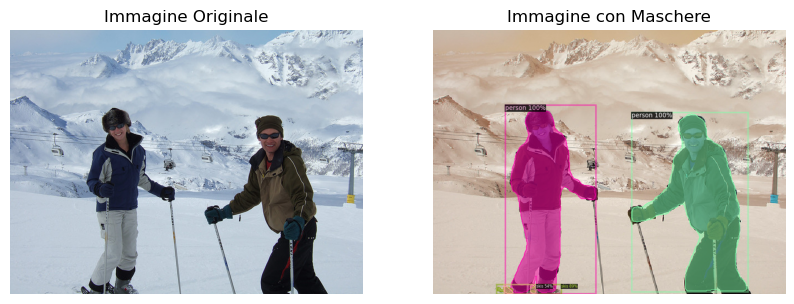

{'category_name': 'person', 'pixels': [[191, 143], [190, 144], [189, 144], [188, 145], [186, 145], [184, 147], [183, 147], [182, 148], [180, 148], [179, 149], [176, 149], [175, 150], [174, 150], [172, 152], [172, 153], [171, 154], [171, 155], [170, 156], [170, 158], [169, 159], [169, 160], [168, 161], [168, 163], [167, 164], [167, 171], [168, 172], [168, 174], [169, 175], [169, 176], [170, 177], [170, 180], [171, 181], [171, 185], [172, 186], [172, 189], [173, 190], [173, 193], [172, 194], [172, 195], [171, 196], [171, 198], [170, 199], [170, 200], [169, 201], [169, 202], [168, 203], [168, 204], [162, 210], [161, 210], [156, 215], [156, 216], [155, 217], [155, 219], [153, 221], [153, 222], [152, 223], [152, 224], [150, 226], [150, 228], [149, 229], [149, 233], [148, 234], [148, 239], [147, 240], [147, 243], [146, 244], [146, 246], [145, 247], [145, 248], [144, 249], [144, 251], [143, 252], [143, 257], [142, 258], [142, 264], [141, 265], [141, 275], [140, 276], [140, 277], [141, 278], [

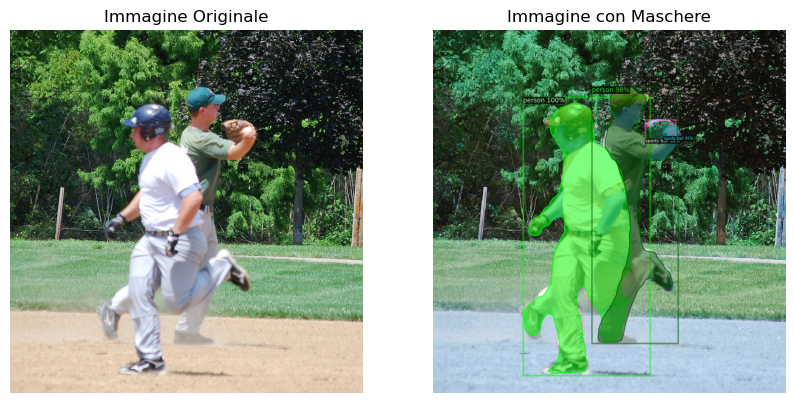

{'category_name': 'person', 'pixels': [[248, 128], [246, 130], [245, 130], [244, 131], [242, 131], [240, 133], [239, 133], [238, 134], [237, 134], [236, 135], [234, 135], [233, 136], [230, 136], [229, 137], [225, 137], [223, 139], [222, 139], [217, 144], [217, 145], [216, 146], [216, 147], [214, 149], [214, 150], [206, 158], [206, 159], [205, 160], [205, 161], [204, 162], [204, 165], [205, 166], [205, 172], [206, 173], [206, 179], [207, 180], [207, 182], [208, 183], [208, 184], [209, 185], [209, 186], [210, 187], [210, 188], [213, 191], [213, 192], [215, 194], [215, 195], [216, 196], [216, 197], [217, 198], [217, 199], [219, 201], [219, 202], [221, 204], [221, 205], [226, 210], [226, 211], [227, 212], [227, 213], [228, 214], [228, 217], [229, 218], [229, 229], [230, 230], [230, 236], [229, 237], [229, 249], [228, 250], [228, 258], [227, 259], [227, 265], [226, 266], [226, 269], [225, 270], [225, 272], [224, 273], [224, 276], [223, 277], [223, 279], [222, 280], [222, 284], [221, 285], [

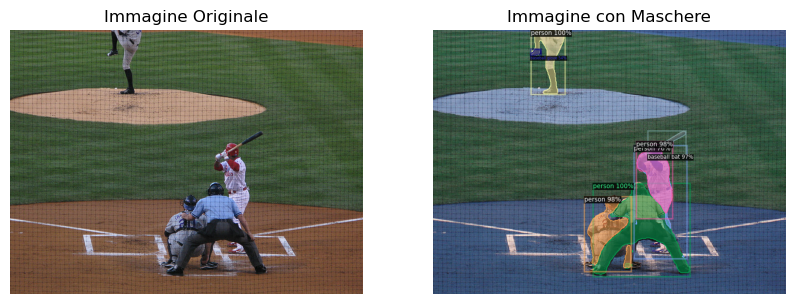

{'category_name': 'person', 'pixels': [[366, 280], [365, 281], [364, 281], [363, 282], [362, 282], [361, 283], [361, 284], [360, 285], [360, 287], [359, 288], [359, 298], [358, 299], [358, 300], [349, 309], [348, 309], [347, 310], [346, 310], [345, 311], [344, 311], [343, 312], [342, 312], [342, 313], [339, 316], [338, 316], [336, 318], [335, 318], [335, 319], [334, 320], [334, 321], [332, 323], [332, 324], [327, 329], [326, 329], [325, 330], [324, 330], [324, 331], [322, 333], [322, 335], [321, 336], [322, 337], [322, 338], [324, 340], [326, 340], [327, 339], [349, 339], [350, 340], [352, 340], [353, 341], [354, 341], [355, 342], [355, 346], [356, 347], [356, 348], [355, 349], [355, 350], [354, 351], [354, 353], [353, 354], [353, 355], [349, 359], [349, 360], [348, 361], [347, 361], [345, 363], [344, 363], [343, 364], [342, 364], [337, 369], [336, 369], [330, 375], [329, 375], [326, 378], [325, 378], [316, 387], [316, 388], [313, 391], [313, 392], [311, 394], [311, 395], [310, 396], [

In [14]:
boxes_predected = np.array([])
for image_filename in image_filenames:
    prediction = process_detectron2_output(image_filename, image_folder, MODEL_USED)
    boxes_predected = np.append(boxes_predected, prediction)


### Calcolo del root min square error

$$RMSE = \sqrt{\frac{1}{n} \sum_{i=1}^{n} \left( (x_i^{\text{pred}} - x_i^{\text{gt}})^2 + (y_i^{\text{pred}} - y_i^{\text{gt}})^2 \right)}




1.	Confrontare maschere binarie: Per ogni istanza, devi confrontare la maschera predetta con quella di verità a terra.
2.	Calcolare la differenza: Sottrarre la maschera predetta dalla maschera di verità a terra.
3.	Calcolare il quadrato delle differenze: Elevare al quadrato la differenza di ogni pixel.
4.	Media degli errori: Calcolare la media degli errori quadratici.
5.	Radice quadrata della media: Calcolare la radice quadrata per ottenere il RMSE.


In [15]:
# Funzione per calcolare l'errore quadratico medio (RMSE)

def calculate_rmse(gt_points, pred_points):
    """Calcola l'RMSE tra due array di punti di lunghezza diversa."""
    num_points = min(len(gt_points), len(pred_points))
    
    gt_resampled = resample_points(gt_points, num_points)
    pred_resampled = resample_points(pred_points, num_points)

    print("lunghezza gt interpol:",gt_resampled)
    print("lunghezza predected interpol:",pred_resampled)
    
    return np.sqrt(np.mean((gt_resampled - pred_resampled) ** 2))

def resample_points(points, num_points):
    """Interpola il poligono per ottenere un numero uniforme di punti."""
    points = np.array(points)
    distances = np.cumsum(np.r_[0, np.sqrt(np.sum(np.diff(points, axis=0) ** 2, axis=1))])
    distances /= distances[-1]
    
    interpolator = interp1d(distances, points, kind='linear', axis=0)
    new_distances = np.linspace(0, 1, num_points)
    
    return interpolator(new_distances)


## Calcolo degli errori

In [16]:
# Funzione per associare le predicted boxes alle GT boxes e calcolare gli errori
def calculate_iou(gt_points, pred_points, img_size=(500, 500)):
    gt_mask = np.zeros(img_size, dtype=np.uint8)
    pred_mask = np.zeros(img_size, dtype=np.uint8)

    cv2.fillPoly(gt_mask, [np.array(gt_points, dtype=np.int32)], 1)
    cv2.fillPoly(pred_mask, [np.array(pred_points, dtype=np.int32)], 1)

    intersection = np.logical_and(gt_mask, pred_mask).sum()
    union = np.logical_or(gt_mask, pred_mask).sum()

    return intersection / union if union > 0 else 0.0

rate = calculate_iou(gt_instances[0]["pixels"][0], boxes_predected[0]["pixels"])

print("Rate IoU prima istanza:",rate)
rmse = calculate_rmse(gt_instances[0]["pixels"][0], boxes_predected[0]["pixels"])
print("RMSE:", rmse)


Rate IoU prima istanza: 0.9118503866211113
lunghezza gt interpol: [[148.         447.        ]
 [160.93097897 422.43113995]
 [172.51816722 397.25276522]
 [168.967223   370.6065755 ]
 [159.54858663 344.96925835]
 [156.         317.43772689]
 [149.02946457 292.80396851]
 [140.24216176 270.18764711]
 [145.06275801 242.84938078]
 [156.46320904 217.74582082]
 [173.17891036 196.55272411]
 [165.32281895 173.16214822]
 [175.69419648 150.76801655]
 [200.24345984 141.        ]
 [220.30092358 156.66974526]
 [218.77148213 182.94271431]
 [242.74859008 191.41630113]
 [243.83161198 214.29476621]
 [247.50708005 240.18139768]
 [251.27499248 265.47499565]
 [275.3026786  279.3857613 ]
 [297.50566765 292.87678535]
 [291.68586544 313.66282691]
 [265.86628815 307.4875863 ]
 [243.89705984 290.51136442]
 [229.62932168 287.91539051]
 [231.58426829 315.61046742]
 [233.53921489 343.30554433]
 [234.24015216 370.9767847 ]
 [231.2341269  398.5775621 ]
 [228.22810164 426.17833951]
 [225.22207637 453.77911692]
 [209.